# Sommaire :


### <a href="#C1"><font color='green'> **Partie 1 : Definition**</font></a>

 - Contexte

<b><hr></b>

### <a href="#C2"><font color='blue'> **Partie 2 : Mise en place de l'espace de travail**</font></a>
 - <a href="#C21"> 2.1 Import des packages</a>
 - <a href="#C22"> 2.2 Repertoire de travail</a>
 - <a href="#C23"> 2.3 Import des datas frames</a>

<b><hr></b>

 
### <a href="#C3"><font color='red'> **Partie 3 : Fréquence de mise à jour de la segmentation**</font></a>

<b><hr></b>

...

# <a name="C1"><font color='green'>**Partie 1 : Contexte**</font></a> 

Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Elle souhaite comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles.

Otis souhaite fournir à ses équipes d'e-commerce cette segmentation de clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Mon rôle est de leur fournir une description actionnable de segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps. 

...

...

# <a name="C2"><font color='blue'>**Partie 2 : Mise en place de l'espace de travail**</font></a> 

### <a name="C21"><font color='blue'>2.1 Imports packages</font></a> 

###### <b><font color='blue'>2.1.0 Requirements</font></b>
- <b>Built-in</b>       : os, warnings
- <b>Data</b>           : pandas, numpy
- <b>Visualisations</b> : matplotlib, seaborn
- <b>Preprocessing</b>  : sklearn, scipy

###### <b><font color='blue'>2.1.1 Imports</font></b>

In [1]:
# Built-in
import os, warnings 

# Calcul
from math import pi

# Data
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

#Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder,StandardScaler,MinMaxScaler,RobustScaler

#metrics
from sklearn.metrics import (mean_squared_error, silhouette_samples,silhouette_score,davies_bouldin_score,
                             adjusted_rand_score,adjusted_mutual_info_score,pair_confusion_matrix)

#cluster
from sklearn.cluster import AgglomerativeClustering, KMeans,MiniBatchKMeans, DBSCAN,MeanShift,SpectralClustering,Birch
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

# feature selection
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import entropy

### <a name="C22"><font color='blue'>2.2 Working directory</font></a> 

In [2]:
os.listdir('data/cleaned/')

['base_client.csv', 'clients.csv', 'rfm_df.csv']

In [5]:
path = 'data/cleaned/'
# A completer
filenameclient = 'clients.csv'
filenamerfm = 'rfm_df.csv'

### <a name="C23"><font color='blue'>2.3 Import DataFrames</font></a> 

In [9]:
clients = pd.read_csv(path+filenameclient,sep=';',index_col=0).dropna()#.sample(10000)
clients['order_purchase_timestamp'] = pd.to_datetime(clients['order_purchase_timestamp'])

rfm_df = pd.read_csv(path+filenamerfm,sep=';',index_col=0).dropna()

# <a name="C3"><font color='red'>**Partie 3 : Fréquence de mise à jour de la segmentation**</font></a> 

### <font color='red'>Import dataframe clients</font>

In [10]:
# Creation du dataset df
def create_dataframe_by_month(clients,offset = 1):
    
    """ Creer un dataframe """
    date_string = "2018-"+str(offset+1)+"-1"
    
    df_mean = clients\
    .drop(columns=['year'])\
       .groupby(['customer_unique_id']).agg('mean')\
       .reset_index()

    # Renommer les colonnes en add suffixe '_mean'
    df_mean.columns = [df_mean.columns[0] ]+ [x + '_Mean' for x in df_mean.columns[1:]] 

    df_month = clients[['customer_unique_id','order_id','NbreDarticleTotal']]\
    .loc[clients.order_purchase_timestamp<pd.to_datetime(date_string)]\
    .groupby(['customer_unique_id']).aggregate({'order_id':'count', 'NbreDarticleTotal':'sum'})\
    .rename(columns={'order_id':'NbreCommande', 'NbreDarticleTotal':'NbreDarticleTotal_Sum'})\
    .reset_index()\
    .merge(df_mean, on='customer_unique_id', how = 'left' )\
    .merge(rfm_df,on='customer_unique_id',how = 'left')
    
    #Selection des variables
    df_res = df_month[['customer_unique_id','Recency', 'Frequency', 'Monetary', 
                       'LastMeanScore_Mean', 'NbreDarticleTotal_Sum']]
    
    # definir index
    df_res = df_res.set_index('customer_unique_id')

    return df_res

### <font color='red'>Creation des bases de clients par moi</font>

In [11]:
scaler0 = StandardScaler()

# initialisation b0
b0 = scaler0.fit_transform(create_dataframe_by_month(clients,offset = 0))

b1 = scaler0.transform(create_dataframe_by_month(clients,offset = 1))
b2 = scaler0.transform(create_dataframe_by_month(clients,offset = 2))
b3 = scaler0.transform(create_dataframe_by_month(clients,offset = 3))
b4 = scaler0.transform(create_dataframe_by_month(clients,offset = 4))
b5 = scaler0.transform(create_dataframe_by_month(clients,offset = 5))
b6 = scaler0.transform(create_dataframe_by_month(clients,offset = 6))
b7 = scaler0.transform(create_dataframe_by_month(clients,offset = 7))
b8 = scaler0.transform(create_dataframe_by_month(clients,offset = 8))

# list des bases
bases = [b0, b1, b2, b3, b4, b5, b6, b7, b8]

### <font color='red'>Evaluation performance du clustering en fonction de l'évolution du temps</font>

In [12]:
b0.shape[0], b1.shape[0],b2.shape[0], b3.shape[0], b4.shape[0], b5.shape[0],b6.shape[0], b7.shape[0], b8.shape[0],

(40543, 47311, 53518, 60251, 66761, 73196, 78966, 84799, 90314)

#### <font color='red'>modèle 2017 v0</font>

In [13]:
#cls = MiniBatchKMeans(n_clusters=k,init = 'k-means++',batch_size=2048)
cl0 = KMeans(n_clusters=6,init = 'k-means++',n_init=10)
cl0.fit(b0)

KMeans(n_clusters=6)

In [14]:
## Predct labels pour chaques mois
labels0 = []

for b in bases:
    labels0.append( cl0.predict(b) )

#### <font color='red'>Un model par mois</font>

In [15]:
# initialisation de la liste des models de clustering
labelsi = []

for i,b in enumerate(bases):
    cli = KMeans(n_clusters=6,init = 'k-means++').fit(b)
    labelsi.append(cli.labels_)

#### <font color='red'>Comparaison model0 vs differents models mensuelle</font>

In [16]:
ARI = []
AMI = []

for i,_ in enumerate(bases):
    ari = adjusted_rand_score(labels0[i], labelsi[i])
    ami = adjusted_mutual_info_score(labels0[i], labelsi[i])

    ARI.append(ari)
    AMI.append(ami)

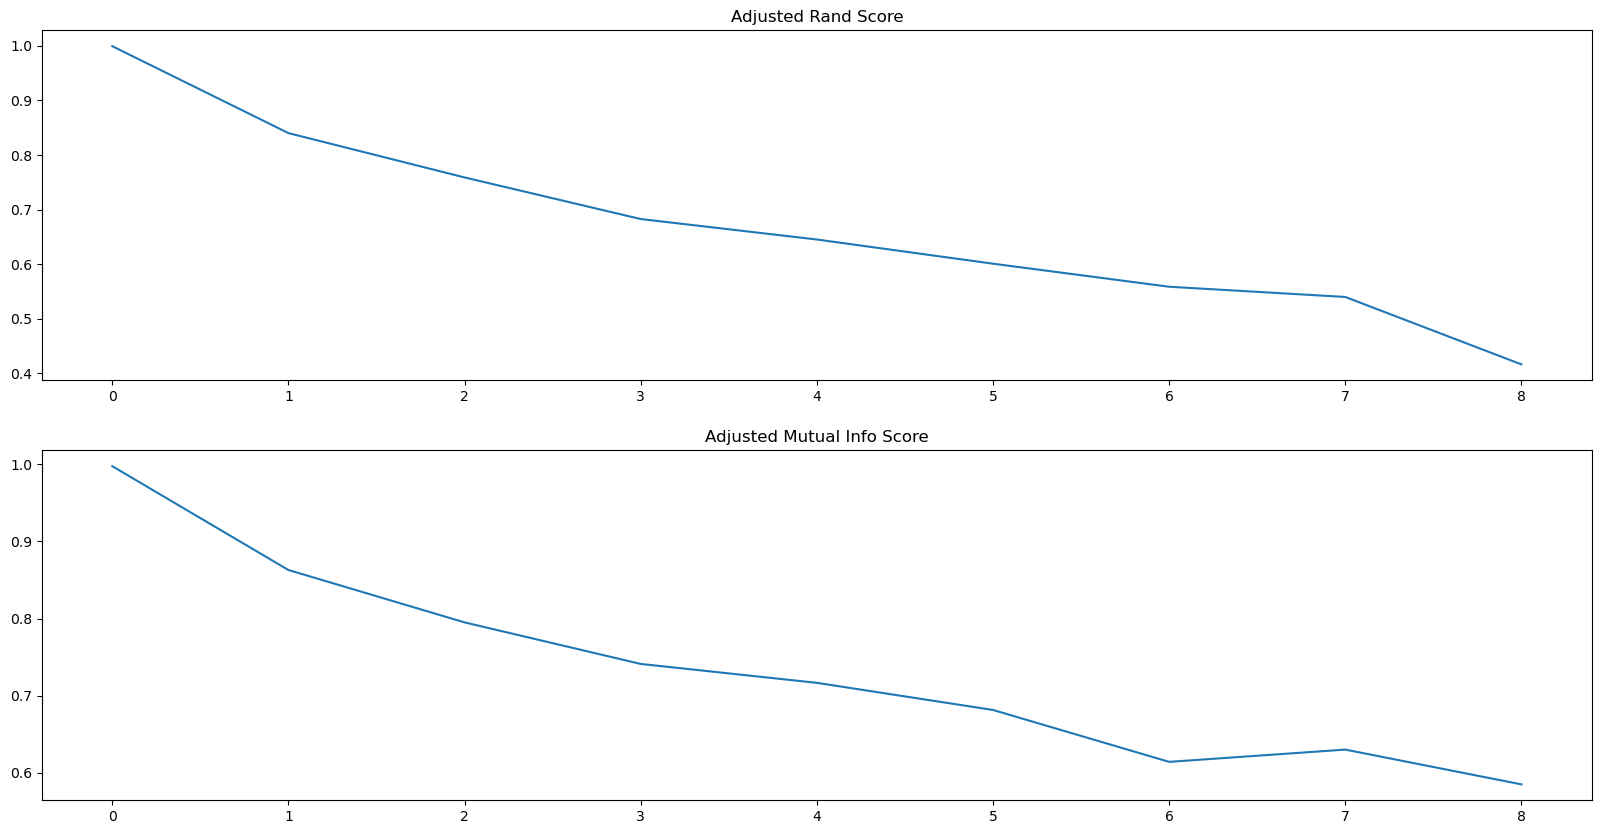

In [17]:
fig, ax = plt.subplots(2,1, figsize=(20, 10) )
sns.lineplot(x = range(0,9), y = ARI,ax = ax[0])
ax[0].set_title('Adjusted Rand Score' )

#ax = fig.add_subplot(122)
sns.lineplot(x = range(0,9), y = AMI, ax = ax[1])
ax[1].set_title('Adjusted Mutual Info Score'  );

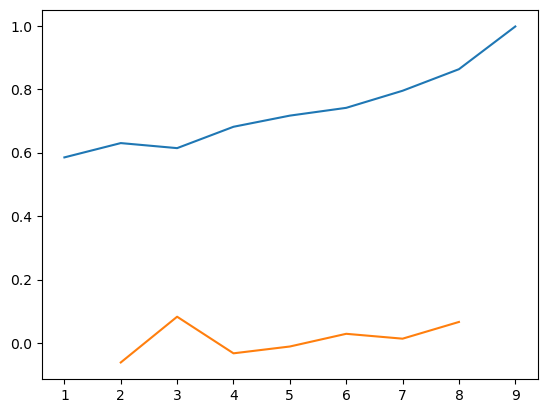

Best number of clusters: 3


In [18]:
last = AMI[-10:]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("Best number of clusters:", k)

Mise à jour tous les 4 mois